<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x39_%E9%95%BF%E7%9F%AD%E6%9C%9F%E8%AE%B0%E5%BF%86%EF%BC%88LSTM%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.长短期记忆
LSTM 中引入了3个门，即输入门（input gate）、遗忘门（forget gate）和输出门（output gate），以及与隐藏状态形状相同的记忆细胞（某些文献把记忆细胞当成一种特殊的隐藏状态），从而记录额外的信息。

### 1.1.输入门，遗忘门，和输出门
与门控循环单元中的重置门和更新门一样，如图6.7所示，长短期记忆的门的输入均为当前时间步输入Xt与上一时间步隐藏状态Ht−1，输出由激活函数为sigmoid函数的全连接层计算得到。如此一来，这3个门元素的值域均为[0,1]。

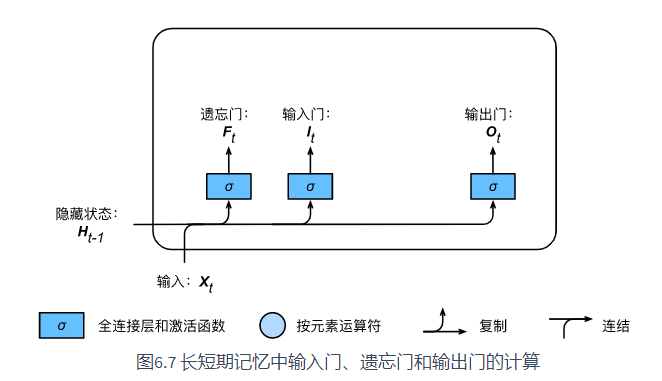



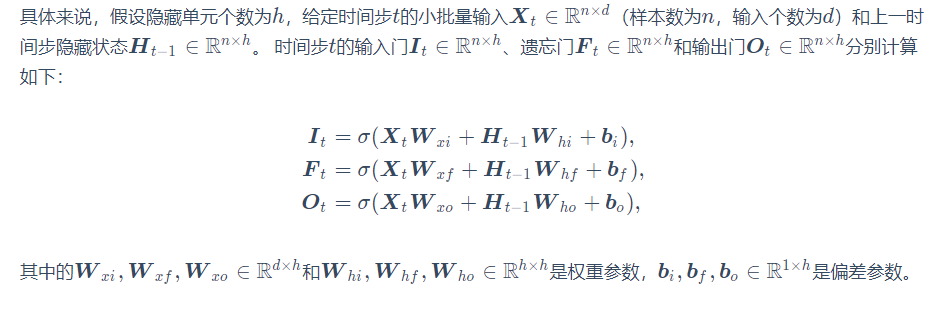

### 1.2.候选记忆细胞
接下来，长短期记忆需要计算候选记忆细胞C˜t。它的计算与上面介绍的3个门类似，但使用了值域在[−1,1]的tanh函数作为激活函数，如图6.8所示。

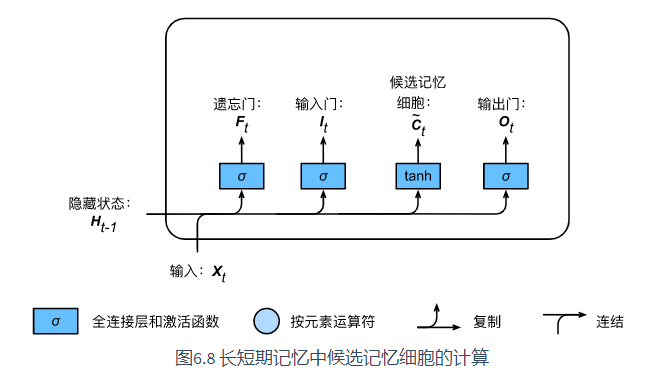

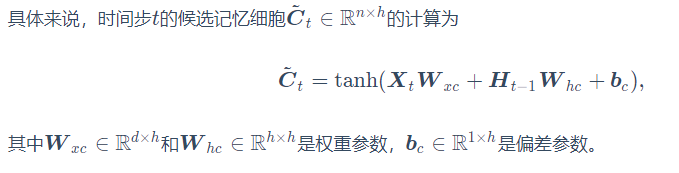

### 1.3.记忆细胞
我们可以通过元素值域在[0,1]的输入门、遗忘门和输出门来控制隐藏状态中信息的流动，这一般也是通过使用按元素乘法（符号为⊙）来实现的。当前时间步记忆细胞Ct的计算组合了上一时间步记忆细胞和当前时间步候选记忆细胞的信息，并通过遗忘门和输入门来控制信息的流动：
$\boldsymbol{C}_{t}=\boldsymbol{F}_{t} \odot \boldsymbol{C}_{t-1}+\boldsymbol{I}_{t} \odot \tilde{\boldsymbol{C}}_{t}$
如图6.9所示，遗忘门控制上一时间步的记忆细胞Ct−1中的信息是否传递到当前时间步，而输入门则控制当前时间步的输入Xt通过候选记忆细胞C˜t如何流入当前时间步的记忆细胞。如果遗忘门一直近似1且输入门一直近似0，过去的记忆细胞将一直通过时间保存并传递至当前时间步。这个设计可以应对循环神经网络中的梯度衰减问题，并更好地捕捉时间序列中时间步距离较大的依赖关系。

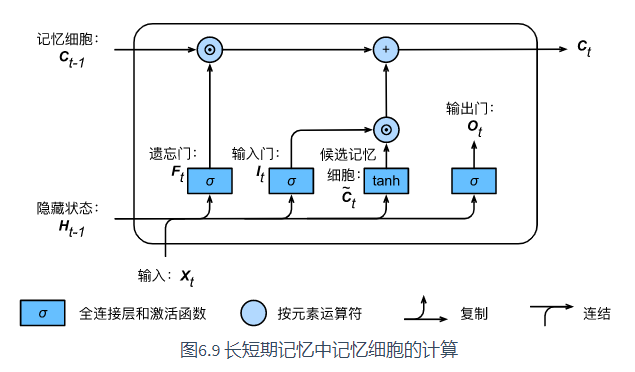


### 1.4.隐藏状态
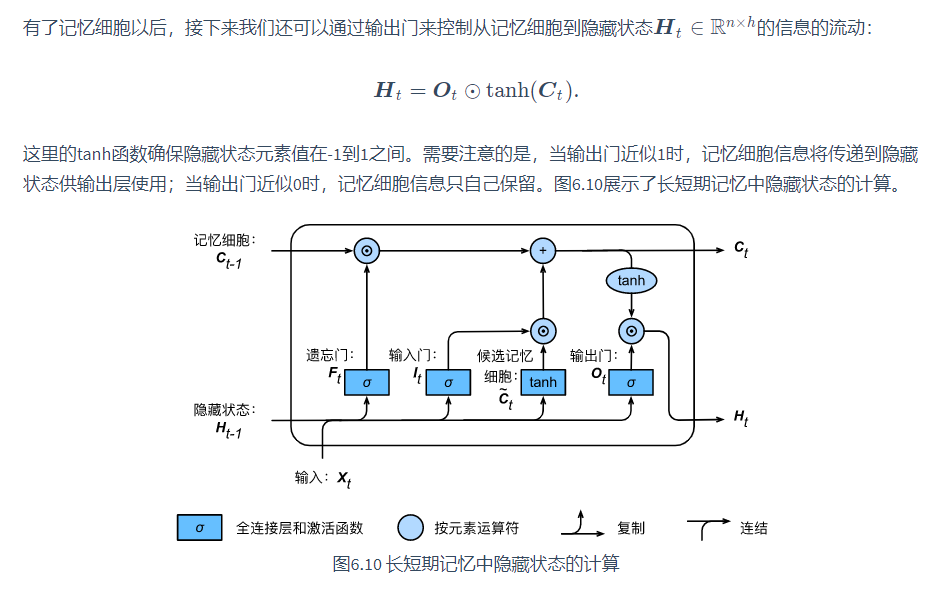

## 2.读取数据集

In [1]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import math
import numpy as np
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dive_Into_Deep_Learning/')
import d2lzh_pytorch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

(corpus_indices, char_to_idx, idx_to_char, vocab_size) = d2l.load_data_jay_lyrics()

Mounted at /content/drive
Wed Feb 24 13:51:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

## 3.从零开始实现
### 3.1.初始化模型参数

In [2]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
print('will use', device)

def get_params():
    def _one(shape):
        ts = torch.tensor(np.random.normal(0, 0.01, size=shape), device=device, dtype=torch.float32)
        return torch.nn.Parameter(ts, requires_grad=True)
    def _three():
        return (_one((num_inputs, num_hiddens)),
                _one((num_hiddens, num_hiddens)),
                torch.nn.Parameter(torch.zeros(num_hiddens, device=device, dtype=torch.float32), requires_grad=True))

    W_xi, W_hi, b_i = _three()  # 输入门参数
    W_xf, W_hf, b_f = _three()  # 遗忘门参数
    W_xo, W_ho, b_o = _three()  # 输出门参数
    W_xc, W_hc, b_c = _three()  # 候选记忆细胞参数

    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device, dtype=torch.float32), requires_grad=True)
    return nn.ParameterList([W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q])


will use cuda


## 4.定义模型
在初始化函数中，长短期记忆的隐藏状态需要返回额外的形状为(批量大小, 隐藏单元个数)的值为0的记忆细胞。

In [3]:
def init_lstm_state(batch_size,num_hiddens,device):
    return (
            torch.zeros((batch_size,num_hiddens),device=device),
            torch.zeros((batch_size, num_hiddens), device=device)
        )

下面根据长短期记忆的计算表达式定义模型。需要注意的是，只有隐藏状态会传递到输出层，而记忆细胞不参与输出层的计算。

In [7]:
def lstm(inputs,state,params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H,C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X,W_xi)+torch.matmul(H,W_hi)+b_i)
        F = torch.sigmoid(torch.matmul(X,W_xf)+torch.matmul(H,W_hf)+b_f)
        O = torch.sigmoid(torch.matmul(X,W_xo)+torch.matmul(H,W_ho)+b_o)
        C_tilda = torch.tanh(torch.matmul(X,W_xc)+torch.matmul(H,W_hc)+b_c)
        C = F*C+I*C_tilda
        H = O* C.tanh()
        Y = torch.matmul(H,W_hq)+b_q
        outputs.append(Y)
    return outputs,(H,C)



### 4.1.训练模型并且创作歌词
同上一节一样，我们在训练模型时只使用相邻采样。设置好超参数后，我们将训练模型并根据前缀“分开”和“不分开”分别创作长度为50个字符的一段歌词。

In [8]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 160, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 40, 50, ['分开', '不分开']


In [9]:
d2l.train_and_predict_rnn(lstm, get_params, init_lstm_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, False, num_epochs, num_steps, lr,
                          clipping_theta, batch_size, pred_period, pred_len,
                          prefixes)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


epoch 40, perplexity 211.326767, time 0.30 sec
 - 分开 我不不你我 我想不你我你 我想不你我你 我想不你我你 我想不你我你 我想不你我你 我想不你我你 我
 - 不分开 我不不你我 我不不你我 我想不你我你 我想不你我你 我想不你我你 我想不你我你 我想不你我你 我想
epoch 80, perplexity 67.451241, time 0.32 sec
 - 分开 我想你你的爱我 你不不觉 我不要这我 我不要这我 我不要这我 我不要这我 我不要这我 我不要这我 
 - 不分开 我想你你的爱我 你不不觉 我不要 我不要 我不不 我不不 我不不觉 我不不觉 我不要这我 我不要这
epoch 120, perplexity 15.433870, time 0.31 sec
 - 分开 我想你这生你 一样依不多 我爱你这生 我的让美走 你的完美  有有有不落 你不不觉 我不了这生 我
 - 不分开 你已在美不口 我有你你 你我的外节 一人后秋 一人用空 不不不动 你不了痛 你不不痛 你一梦空 你
epoch 160, perplexity 4.190987, time 0.31 sec
 - 分开 我不好这生活 我知好觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活
 - 不分开 我已经这生活 我不好觉 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活


## 5.简洁实现

In [10]:
lr = 1e-2
lstm_layer = nn.LSTM(input_size=vocab_size,hidden_size=num_hiddens)
model = d2l.RNNModel(lstm_layer,vocab_size)
d2l.train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes)

epoch 40, perplexity 1.022649, time 0.05 sec
 - 分开 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活 不知不觉 你已经离开我
 - 不分开 我跟了这样牵着你的手不放开 爱可不可以简简单单没有伤害 你 靠着我的肩膀 你 在我胸口睡著 像这样
epoch 80, perplexity 1.013912, time 0.05 sec
 - 分开 我跟了这节奏 后知后觉 又过了一个秋 后知后觉 我该好好生活 我该好好生活 不知不觉 你已经离开我
 - 不分开 我有多烦恼多 没有你烦 我有多烦恼  没有你烦我有多烦恼多难熬  穿过云层 我试著努力向你奔跑 爱
epoch 120, perplexity 1.019030, time 0.05 sec
 - 分开 几十个世纪后出土发现 泥板上的字迹依然清晰可见 我给你的爱写在西元前 深埋在美索不达米亚平原 几十
 - 不分开 爱能不能够永远单纯没有悲哀 我 想带你骑单车 我 想和你看棒球 想这样没担忧 唱着歌 一直走 我想
epoch 160, perplexity 1.018094, time 0.06 sec
 - 分开 爱情来的太快就像龙卷风 离不开暴风圈来不及逃 我不能再想 我不能再想 我不 我不 我不能 爱情走的
 - 不分开 爱有不能 在知后觉 你已经离开我 不知不觉 我跟了这节奏 后知后觉 后知后觉 迷迷蒙蒙 你给的梦 


## 6.小结
1. 长短期记忆的隐藏层输出包括隐藏状态和记忆细胞。只有隐藏状态会传递到输出层。
2. 长短期记忆的输入门、遗忘门和输出门可以控制信息的流动。
3. 长短期记忆可以应对循环神经网络中的梯度衰减问题，并更好地捕捉时间序列中时间步距离较大的依赖关系。